In [42]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="bright",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 5
YEAR = 365 * 24 * 60 * 60
USE_SIMULATED_TIME = False

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, years"
else:
    X_LABEL = "Time step number"


data = {
    "CPR": load_data("thermal_cpr", n_newest=NUM_SIMS),
    "Schur": load_data("thermal_schur", n_newest=NUM_SIMS),
    "Random": load_data("thermal_random", n_newest=NUM_SIMS),
    "Solver selection": load_data("thermal_dynamic", n_newest=NUM_SIMS),
}

save_media_path = Path('media')
save_media_path.mkdir(exist_ok=True)

Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_22.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_23.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_24.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_25.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_26.npy
Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_15.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_16.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_17.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_18.npy
/home/firedrake/workspace/porepy_workspace/solver_selec

CPR 0.28182268142700195 0.0
CPR 0.2842308282852173 0.004816293716430664
CPR 0.2827146053314209 0.006956815719604492
CPR 0.28442662954330444 0.009880542755126953
CPR 0.28786134719848633 0.021918058395385742
Schur 0.35884904861450195 0.0
Schur 0.35243892669677734 0.012820243835449219
Schur 0.3510335286458333 0.012820243835449219
Schur 0.3533453941345215 0.014252185821533203
Schur 0.3533414363861084 0.014252185821533203
Random 0.28435516357421875 0.0
Random 0.23868107795715332 0.09134817123413086
Random 0.2773948510487874 0.16181540489196777
Random 0.2541036009788513 0.1705925464630127
Random 0.27553863525390626 0.177048921585083
Solver selection 0.18795204162597656 0.0
Solver selection 0.20142066478729248 0.026937246322631836
Solver selection 0.2546185652414958 0.17306232452392578
Solver selection 0.2807474136352539 0.17306232452392578
Solver selection 0.2616272926330566 0.17586755752563477


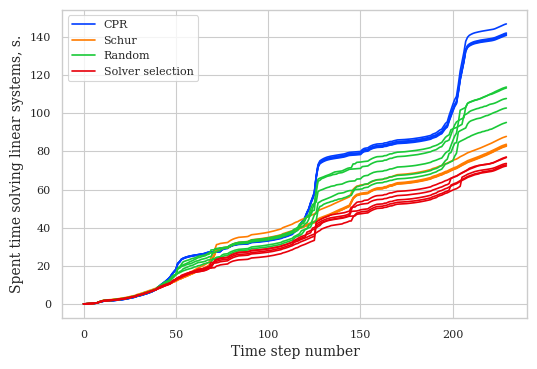

In [43]:
color_iter = -1
plt.figure(figsize=(6, 4))
for name, values in data.items():
    color_iter += 1
    total = []
    make_label = True
    for perf in values:
        result = sum_per_time_step(
            make_solve_linear_system_time(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )

        total.append(result[-1])
        result = np.cumsum(result)
        x = np.arange(len(result))
        if USE_SIMULATED_TIME:
            x = make_simulation_time(perf, converged=CONVERGED) / YEAR

        if make_label:
            plt.plot(x, result, color=f"C{color_iter}", label=name)
            make_label = False
        else:
            plt.plot(x, result, color=f"C{color_iter}")
        print(name, np.mean(total), np.max(total) - np.min(total))

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

CPR 142.5125789642334 6.017240047454834
Schur 84.080397939682 5.12140679359436
Random 106.53146653175354 18.570005416870117
Solver selection 74.55823073387145 4.719325542449951


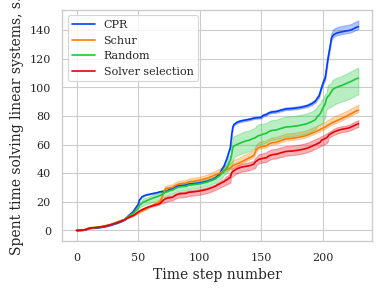

In [50]:
color_iter = -1
best_time = float('inf')
plt.figure(figsize=(4, 3))
for name, values in data.items():
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])
        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    if USE_SIMULATED_TIME:
        assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

CPR 142.5125789642334 6.017240047454834
Schur 84.080397939682 5.12140679359436
Random 106.53146653175354 18.570005416870117
Solver selection 74.55823073387145 4.719325542449951


Text(0, 0.5, 'Spent time solving linear systems, s.')

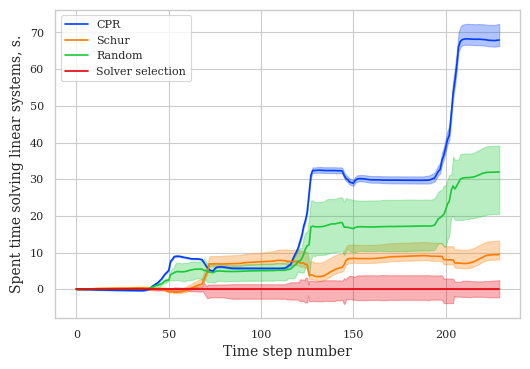

In [45]:
color_iter = -1
plt.figure(figsize=(6, 4))
for name, values in data.items():
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0) - best
    min_ = np.min(interp_data, axis=0) - best
    mean = np.mean(interp_data, axis=0) - best
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

# if save_media_path is not None:
#     plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

CPR (average)


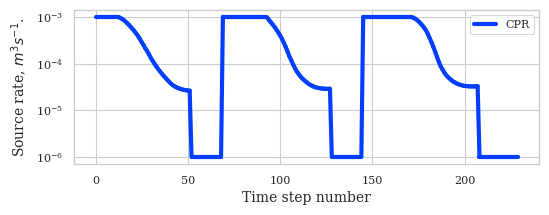

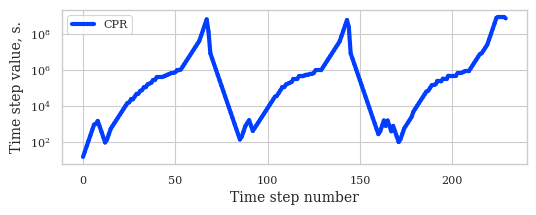

Schur (average)


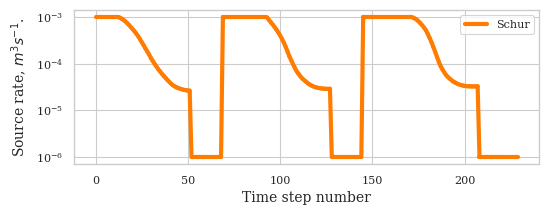

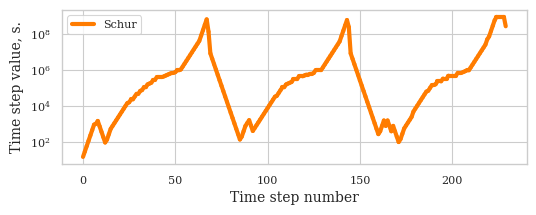

Random (average)


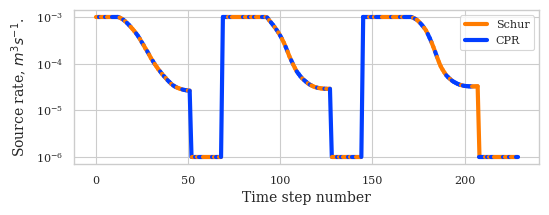

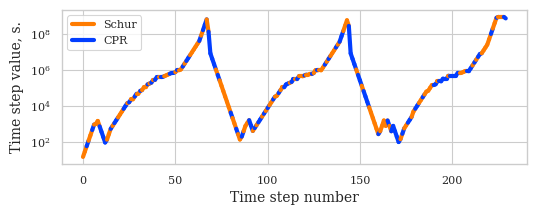

Solver selection (average)


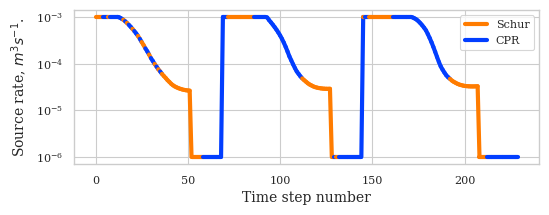

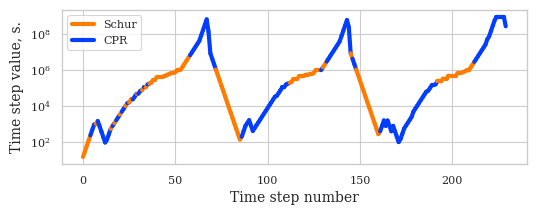

In [46]:
def color_using_schur(x, values, using_schur):
    lw = 3
    if not USE_SIMULATED_TIME:
        x = np.arange(values.size)
    cpr_color = "C0"
    schur_color = "C1"
    label_schur = False
    label_cpr = False

    for i in range(len(x)):
        x_ = x[i : i + 2]
        val = values[i : i + 2]
        if not using_schur[i]:
            kwargs = dict(color=cpr_color)
            if not label_cpr:
                kwargs["label"] = "CPR"
                label_cpr = True
        else:
            kwargs = dict(color=schur_color)
            if not label_schur:
                kwargs["label"] = "Schur"
                label_schur = True
        plt.plot(x_, val, linewidth=lw, **kwargs)
        plt.legend()


def make_using_schur_indices(perf: Sequence[SolverSelectionData], converged=True):
    using_schur = np.array(
        ["schur_cd" in data.config["gmres"]["preconditioner"] for data in perf]
    )
    if converged:
        return using_schur[make_converged_indices(perf)]
    return using_schur


def make_average_decision(values):
    values = np.array(values, dtype=int)
    values = values.sum(axis=0)
    mean = NUM_SIMS / 2
    return values > mean


for name, vals in data.items():
    using_schur_list = []
    time_step_list = []
    inlet_rate_list = []
    sim_time_list = []
    for perf in vals:
        using_schur_list.append(make_using_schur_indices(perf, converged=CONVERGED))
        time_step_list.append(make_time_step(perf, converged=CONVERGED))
        inlet_rate_list.append(make_inlet_rate(perf, converged=CONVERGED))
        sim_time_list.append(make_simulation_time(perf, converged=CONVERGED))

    using_schur_mean = make_average_decision(using_schur_list)

    print(name, "(average)")
    plt.figure(figsize=(6, 2))
    color_using_schur(sim_time_list[0], inlet_rate_list[0], using_schur_mean)
    plt.ylabel("Source rate, $m^3 s^{-1}$.")
    plt.xlabel(X_LABEL)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"thermal_source_{name}.pdf", bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel(X_LABEL)
    color_using_schur(sim_time_list[0], time_step_list[0], using_schur_mean)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"thermal_dt_{name}.pdf", bbox_inches="tight")
    plt.show()

CPR 0.28786134719848633 0.021918058395385742
Schur 0.3533414363861084 0.014252185821533203


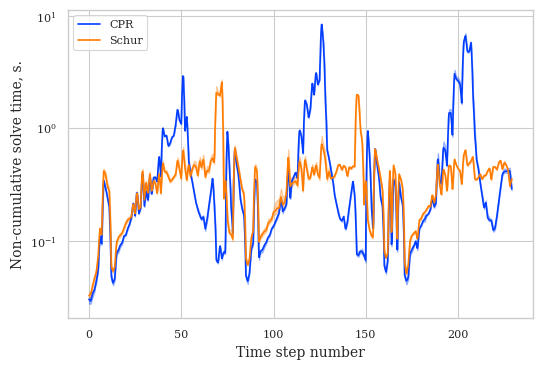

In [47]:
color_iter = -1
plt.figure(figsize=(6, 4))

for name, values in data.items():
    if name not in ('CPR', 'Schur'):
        continue
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = sum_per_time_step(
            make_solve_linear_system_time(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)

    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Non-cumulative solve time, s.")
plt.yscale('log')

CPR 87.0 0.0
Schur 47.0 0.0


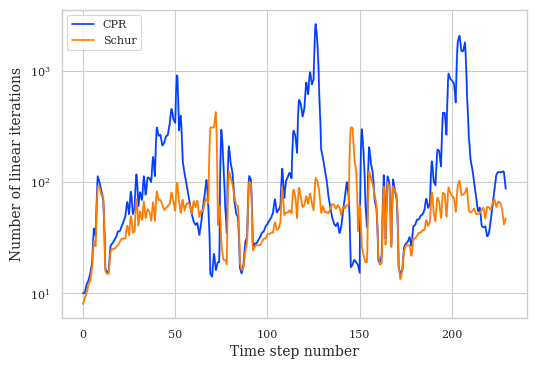

In [48]:
color_iter = -1
plt.figure(figsize=(6, 4))

for name, values in data.items():
    if name not in ('CPR', 'Schur'):
        continue
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = sum_per_time_step(
            make_num_linear_iters(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)

    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Number of linear iterations")
plt.yscale('log')